In [9]:
##Problem 02:

In [1]:

import numpy as np
import random
from scipy.special import gamma, factorial
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import tqdm
from numba import jit
from numba import njit, prange
import time
from scipy.integrate import solve_ivp

In [4]:
# Poisson spike train generation.
def inhomo_PoissonSpikeTrain(dt,T,rx,Total_time):
    rand_unis = np.random.uniform(0,1,(1,len(Total_time)))
    num_spikes = 0
    spikes_x = np.zeros_like(Total_time)
    spike_time_x = np.zeros((int(T*10**9)))
    for i in range(len(Total_time)):
        prob = rx[i] * dt # rx is time-dependent rate.
        if (prob > rand_unis[0,i]):
            spike_time_x[num_spikes] = Total_time[i]
            spikes_x[i] = 1
            num_spikes += 1
        else:
            spikes_x[i] = 0
    spike_time_x = spike_time_x[0:num_spikes]
    return spike_time_x, spikes_x

In [2]:
def EulerMethod_poisson_input(spike_time_x,spikes_x,u_rest,u_thres,dt,tau_m,R,w,T,Total_time,u_ic):
    nspike = 0
    maxns=round(T*10**9); # max numbers of spikes
    s = np.zeros((1,maxns))
    u = np.zeros_like(Total_time)
    u_saved = np.zeros_like(Total_time)
    u[0] = u_ic
    u_saved[0] = u_ic 
    
    for i in range(len(Total_time)-1): 

        # Euler update to u - mem pot
        u[i+1] = u[i] + (dt/tau_m)*(-u[i] + w * R * spikes_x[i] )

        # If there are spikes
        if(u[i+1]>=u_thres):
            s[0,nspike]=Total_time[i]       

            # Update cumulative number of spikes
            nspike+=1
        
            # This makes plots of u(t) look better.
            # All action potentials reach u_thres exactly. 
            u_saved[i+1]=u_thres

            # Reset mem pot.
            u[i+1]=u_rest
        else:
            u_saved[i+1]=u[i+1]

    s=s[0,0:nspike] # Get rid of padding in s
    
    return u, u_saved, s

In [5]:
# Total_time  for sim
T = 500 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 # sec
R = 500 * 10**6 # Ohms

Num_synapses = 10**2
w = 10**3 *5 / 10**12 # Amps

# Inhomogeneous rate for Poisson spike trains
rx = Num_synapses *5* ( np.ones_like((Total_time)) ) # Hz

np.random.seed(2)

u_ic = 1 /1000

spike_time_x, spikes_x = inhomo_PoissonSpikeTrain(dt,T,rx,Total_time)

u, u_saved, s = EulerMethod_poisson_input(spike_time_x,spikes_x,
                                             u_rest,u_thres,dt,tau_m,R,w,T,Total_time,u_ic)


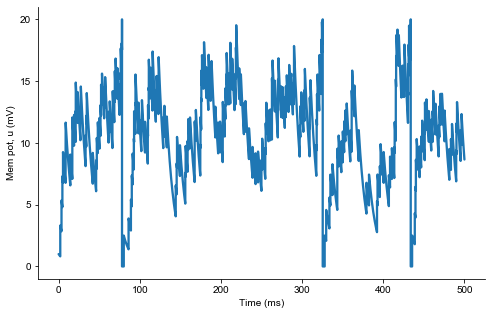

In [6]:
# Create figure and plot 
## Plot results
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth":2.3})

plt.plot(Total_time*10**3 ,u_saved*10**3)

plt.xlabel('Time (ms)')
plt.ylabel('Mem pot, u (mV)')

sns.despine()
plt.show()

In [7]:
num_ics = 10
initial_condition = np.linspace(u_rest,u_thres,num_ics)
num_realizations = 2*10**3

FPT = np.zeros((num_ics,num_realizations))

# Total_time  for sim
T = 200 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 # sec
R = 500 * 10**6 # Ohms

Num_synapses = 10**3
w = 10**4 *2 / 10**12 # Amps

# Inhomogeneous rate for Poisson spike trains
rx = Num_synapses *1* ( np.ones_like((Total_time)) ) # Hz

np.random.seed(12)

for j in range(num_realizations):
    for i in range(num_ics):
        u_ic = initial_condition[i]
        spike_time_x, spikes_x = inhomo_PoissonSpikeTrain(dt,T,rx,Total_time)
        u, u_saved, s = EulerMethod_poisson_input(spike_time_x,spikes_x,
                                             u_rest,u_thres,dt,tau_m,R,w,T,Total_time,u_ic)
        
        FPT[i,j] = np.min(np.where(u_saved==u_thres)) * dt # in secs
        
mean_FPT = np.mean(FPT,axis=1) # in secs

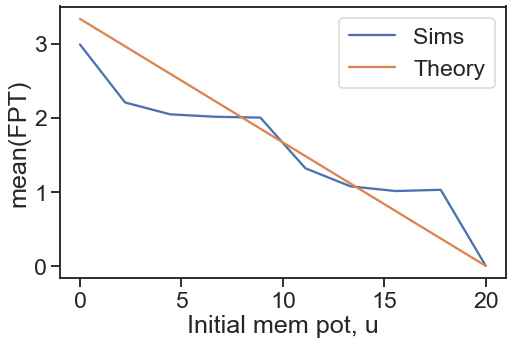

In [8]:
# Create figure and plot 
## Plot results
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth":2.3})

plt.plot(initial_condition*1000,mean_FPT*1000, label='Sims') # in msecs

T_theory = -(100 - 120*np.exp(6 - (3*initial_condition*1000)/10) 
             - np.exp(36) * (-20 + initial_condition*1000) + initial_condition*1000)/(6 - 6*np.exp(36) )
plt.plot(initial_condition*1000, T_theory, label='Theory')

plt.xlabel('Initial mem pot, u')
plt.ylabel('mean(FPT)')
plt.legend()

plt.show()